### Abstract
This project explores various time series techniques to analyze and forecast the price of a single stock. It includes classical statistical models, neural networks, and diagnostic tools.

1. Separate the time series into trend, seasonal, residual components

2. Use various models to predict the price of a single stock

- Exponential smoothing models 
    - Simple exponential
    - Holts Linear
    - Holts Winter
    - residual analysis of Holt-Winters model

- autoregressive model
    - Use PACF to determine optimal lag order
    - Build and forecast using AR model

- ARIMA model
    - Fit and forecast using ARIMA for non-stationary series

- GARCH model
    - Model and forecast volatility of returns

- Harmonic regression
    - Use Fourier series features for cyclical pattern modeling

- LSTM
    - Sequence modeling using PyTorch-based LSTM


### Python Environment
To setup the environment using `conda`, please run: 
```
conda create -n venv python=3.11.13
conda activate venv
pip install -r requirements.txt
```

Import all relevant libraries

In [110]:
# import all relevant libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


import plotly.graph_objects as go
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

from statsmodels.stats.diagnostic import acorr_ljungbox
import plotly.express as px


from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import statsmodels.api as sm
from scipy.special import inv_boxcox
from scipy.stats import boxcox


from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX



from arch import arch_model

import pmdarima as pm 

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim


Define plotting functions
- plot_func: Visualizes predictions from multiple exponential smoothing models on a single plot.
- plot_forecasts: Compares model forecasts against actual test data.

In [111]:
# define plotting functions
def plot_func(forecast1: list[float],
              forecast2: list[float],
              forecast3: list[float],
              title: str) -> None:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], name='Train'))
    fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], name='Test'))
    fig.add_trace(go.Scatter(x=test['ds'], y=forecast1, name='Simple'))
    fig.add_trace(go.Scatter(x=test['ds'], y=forecast2, name="Holt's Linear"))
    fig.add_trace(go.Scatter(x=test['ds'], y=forecast3, name='Holt Winters'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=700, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')
    return fig.show()


def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], name='Train'))
    fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], name='Test'))
    fig.add_trace(go.Scatter(x=test['ds'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Stock Price')

    return fig.show()

# define evaluation metric functions
def smape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    denom = (np.abs(y) + np.abs(yhat))
    return 200 * np.mean(np.where(denom==0, 0, np.abs(y - yhat) / denom))

def rmse(y, yhat): 
    y, yhat = np.asarray(y), np.asarray(yhat)
    return np.sqrt(np.mean((y - yhat)**2))

def mae(y, yhat): 
    return np.mean(np.abs(np.asarray(y) - np.asarray(yhat)))

def mase(y_train, y, yhat, m=12):
    # seasonal naive in-sample MAE as scale
    naive = np.abs(y_train[m:] - y_train[:-m]).mean()
    return mae(y, yhat) / (naive if naive != 0 else np.nan)

def coverage(y, lo, hi):
    y, lo, hi = map(np.asarray, (y, lo, hi))
    return 100 * np.mean((y >= lo) & (y <= hi))


Import data from Yahoo Finance and decompose the time series

/var/folders/vd/0zsw2_6958n8zt4zkjgw3ht00000gn/T/ipykernel_23343/1748706923.py:5: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


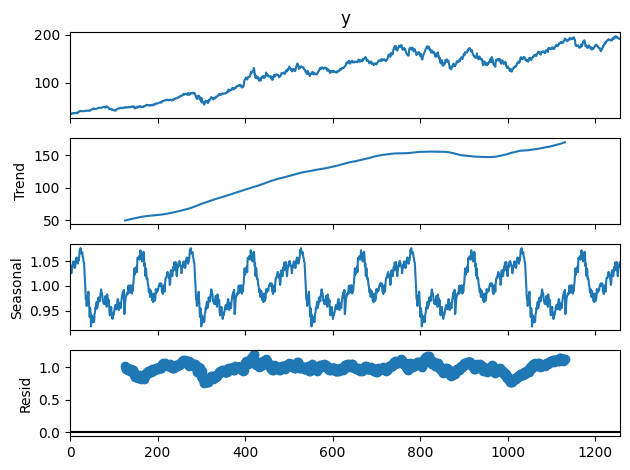

In [112]:
# Import data from Yahoo Finance and decompose the time series

# Download data for a stock (e.g., Apple) from the last 5 years
ticker = "AAPL"
data = yf.download(ticker, start="2019-01-01", end="2024-01-01")

# Use 'Close' price and reset index
df = data[['Close']].reset_index()
df.columns = ['ds', 'y']  # Rename for Prophet compatibility
df.head()

# Plot the decomposition for multiplicative series

decomposition_plot_multi = seasonal_decompose(df['y'],
                                              model='multiplicative',
                                              period=252)  # Assuming daily data with yearly seasonality, annual trading days ~252
decomposition_plot_multi.plot()
plt.show()

### Data Preparation
- Apply Box-Cox transformation to stabilize variance and generate a stationary series.
- Split the dataset into training and testing sets using an 80:20 ratio.


In [113]:
# Build df, split data

# generate stationary series by boxcox transformation
df['y_boxcox'], lam = boxcox(df['y'])
df["y_diff"] = df["y_boxcox"].diff()
df["y_stationary"] = df["y_diff"].diff()
df.dropna(inplace=True)

df['date'] = pd.to_datetime(df['ds'])
df['month_num'] = df['date'].dt.month

# Split train and test
test_size = int(len(df) * 0.20)
train = df.iloc[:-test_size].copy()
test = df.iloc[-test_size:].copy()

y_train = train['y'].to_numpy()
y_test  = test['y'].to_numpy()
H = len(y_test)


SP = 252 # seasonal period


In [ ]:
# Baseline: 
# ----------  Baseline forecasters ----------

def seasonal_naive_forecast(y_train, h, m):
    if len(y_train) < m:
        # fallback if not enough history for one full season
        return naive_forecast(y_train, h)
    last_season = y_train[-m:]
    return np.resize(last_season, h)  # repeats as needed

fcst_snaive = seasonal_naive_forecast(y_train, H, SP)
plot_forecasts(fcst_snaive, 'Seasonal Naive Forecast')


### Exponential Smoothing Models

This section implements and compares three classic exponential smoothing techniques to forecast stock prices:

1. **Simple Exponential Smoothing**
2. **Holt’s Linear Trend Method**
3. **Holt-Winters Seasonal Method**

### 📌 Model Comparison: Key Advantages

| Model                  | Advantages                                                              |
|------------------------|-------------------------------------------------------------------------|
| **Simple Exponential** | Best for short-term forecasts with no trend or seasonality.             |
| **Holt’s Linear Trend**| Handles time series with consistent upward or downward trends.          |
| **Holt-Winters Seasonal** | Captures both trend and seasonal patterns, ideal for complex time series. |



In [ ]:
# Implement predictive models: simple exponential smoothing, Holt's linear trend, and Holt-Winters seasonal method



# ----- Simple exponential smoothing -------
model_simple = SimpleExpSmoothing(train['y']).fit(optimized=True)
forecasts_simple = model_simple.forecast(len(test))

# ----------- Holt's linear trend ----------
model_holt = Holt(train['y'], damped_trend=True).fit(optimized=True)
forecasts_holt = model_holt.forecast(len(test))

# ---------- Holt Winters model ------------
#    Use multiplicative seasonality only if strictly positive data
seasonal_kind = 'mul' if (train['y'] > 0).all() else 'add'
model_holt_winters = ExponentialSmoothing(train['y'], trend='mul', 
                                          seasonal=seasonal_kind, seasonal_periods=SP)\
                                          .fit(optimized=True)
forecasts_holt_winters = model_holt_winters.forecast(test_size)

fcst_ets = model_holt_winters.forecast(test_size).to_numpy()


# Plot the forecasts
plot_func(forecasts_simple, forecasts_holt, forecasts_holt_winters,  "Holt-Winters Exponential Smoothing")

print(model_holt_winters.summary())

/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one o

                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                 1005
Model:             ExponentialSmoothing   SSE                           4187.310
Optimized:                         True   AIC                           1948.206
Trend:                   Multiplicative   BIC                           3210.781
Seasonal:                Multiplicative   AICC                          2128.985
Seasonal Periods:                   252   Date:                 Sat, 23 Aug 2025
Box-Cox:                          False   Time:                         10:32:43
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                1.0000000                alpha                 True
smoothing_trend       

### 🔍 Residual Analysis for Holt-Winters Model

After fitting the Holt-Winters model, I perform a residual analysis to assess the model’s assumptions and performance.

Steps

1. Plot ACF and PACF of the residuals to inspect serial correlations  
   *This helps verify whether any autocorrelation remains after fitting the model, which would indicate model misspecification.*

2. Apply the Ljung-Box test to examine if residuals are independently distributed  
   *This formal statistical test complements visual inspection and confirms whether residuals behave like white noise.*  
   - For the first 4 lags, we cannot reject the null that the residuals are independently distributed.

3. Visualize the distribution of residuals to assess normality  
   *A normal-looking distribution supports assumptions made by many statistical models.*

4. Check the mean of residuals  
   *A mean close to zero indicates unbiased predictions from the model*


             ds           y    y_boxcox     y_diff  y_stationary       date  \
2    2019-01-04   35.276718   66.093039   3.379376     12.205228 2019-01-04   
3    2019-01-07   35.198208   65.908471  -0.184567     -3.563944 2019-01-07   
4    2019-01-08   35.869186   67.489022   1.580551      1.765118 2019-01-08   
5    2019-01-09   36.478313   68.930037   1.441015     -0.139536 2019-01-09   
6    2019-01-10   36.594902   69.206513   0.276476     -1.164539 2019-01-10   
...         ...         ...         ...        ...           ...        ...   
1002 2022-12-22  130.391083  337.589899 -10.247605    -20.273005 2022-12-22   
1003 2022-12-23  130.026230  336.416193  -1.173706      9.073899 2022-12-23   
1004 2022-12-27  128.221649  330.622632  -5.793560     -4.619854 2022-12-27   
1005 2022-12-28  124.287163  318.059076 -12.563556     -6.769996 2022-12-28   
1006 2022-12-29  127.807510  329.295799  11.236722     23.800278 2022-12-29   

      month_num  fittedvalues  residuals  
2       

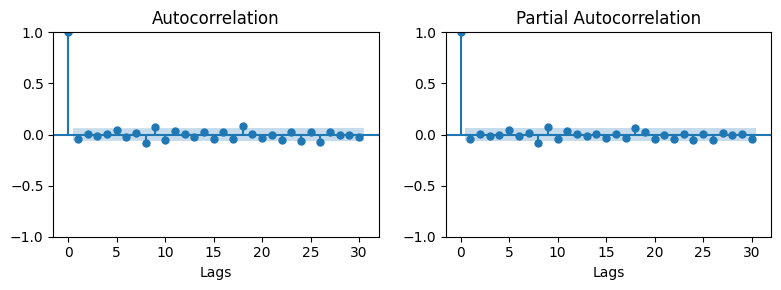

      lb_stat  lb_pvalue
1    1.540067   0.214608
2    1.556132   0.459293
3    1.812539   0.612210
4    1.812631   0.770171
5    4.206702   0.520056
6    4.671789   0.586543
7    4.991258   0.661030
8   12.058503   0.148613
9   18.112736   0.033888
10  20.730491   0.023053


0.027546703125614722


In [116]:
# residual analysis for Holt-Winters model

# Appending residuals and fitted values to the train dataframe
train['fittedvalues'] = model_holt_winters.fittedvalues
train['residuals'] = model_holt_winters.resid
print(train)


# ---------- Plot ACF and PACF -----------
fig, ax = plt.subplots(1,2,figsize=(8,3))
plot_acf(train['residuals'], lags=30, ax=ax[0])
ax[0].set_xlabel('Lags')
plot_pacf(train['residuals'], lags=30, ax=ax[1])
ax[1].set_xlabel('Lags')
plt.tight_layout()
plt.show()

# ----- Ljunghbox test for residuals ----
print(acorr_ljungbox(train['residuals'], return_df=True))


# -------- Histogram of residuals -------
fig = px.histogram(train, x="residuals")
fig.update_layout(template="simple_white", font=dict(size=18),
                  title_text='Distribution of Residuals',
                  width=700, title_x=0.5, height=400,
                  xaxis_title='Residuals', yaxis_title='Count')
fig.show()

# ---------- Mean of residuals -----------
print(train['residuals'].mean())

## 🔁 Autoregressive (AR) Model

This section implements an Autoregressive (AR) model to forecast a stationary time series, transformed using Box-Cox. AR models assume that future values depend linearly on past values, making them effective for series with strong autocorrelation and minimal trend or seasonality.

> ⚠️ **Note:** AR models are **not ideal for volatile or highly nonlinear data** such as individual stock prices.

---

### ✅ Why Use AR?

- **Captures short-term dependencies** in time series
- **Simple yet powerful** for stationary data
- Best suited for **stable, mean-reverting patterns**

---

### 🛠️ Modeling Steps

1. **Ensure Stationarity**
   - Apply transformations (e.g. Box-Cox, differencing) to stabilize mean and variance
   - Use the Augmented Dickey-Fuller (ADF) test to check for stationarity
   - A low p-value (< 0.05) suggests the series is stationary

2. **Select Lag Order**
   - Use ACF and PACF plots to visually identify appropriate lags
   - Alternatively, use `ar_select_order` for automatic lag selection

3. **Fit and Forecast**
   - Fit the AR model on the stationary series
   - Forecast future values and **revert the Box-Cox transformation** to obtain actual values


In [117]:
int(len(data))*0.2
len(test)

251

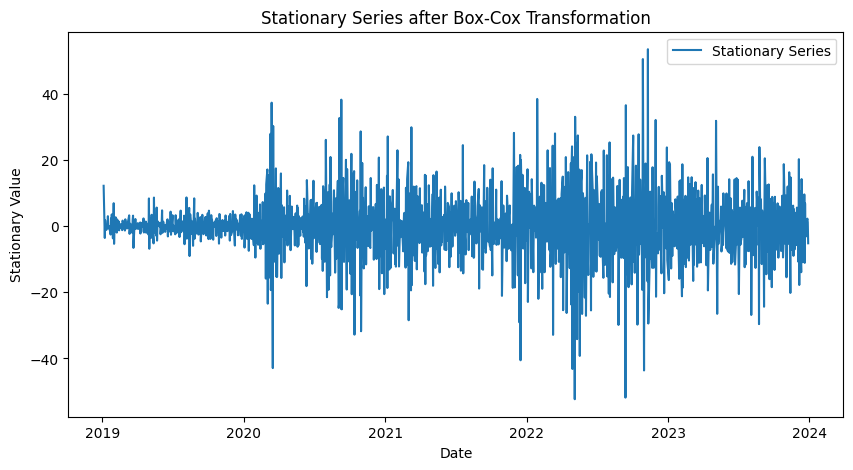

ADF Statistic: -13.11761995589345
p-value: 1.587138068716592e-24


/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.



                            AutoReg Model Results                             
Dep. Variable:           y_stationary   No. Observations:                 1005
Model:                    AutoReg(10)   Log Likelihood               -3477.539
Method:               Conditional MLE   S.D. of innovations              7.973
Date:                Sat, 23 Aug 2025   AIC                           6979.077
Time:                        10:20:19   BIC                           7037.910
Sample:                            10   HQIC                          7001.443
                                 1005                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0211      0.253     -0.083      0.934      -0.516       0.474
y_stationary.L1     -0.9479      0.031    -30.193      0.000      -1.009      -0.886
y_stationary.L2     -0.8992 

/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported i

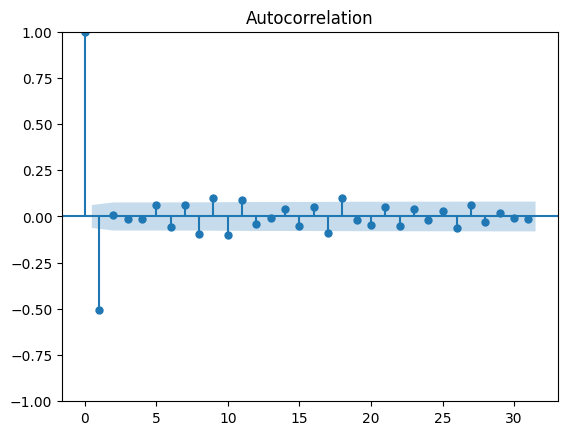

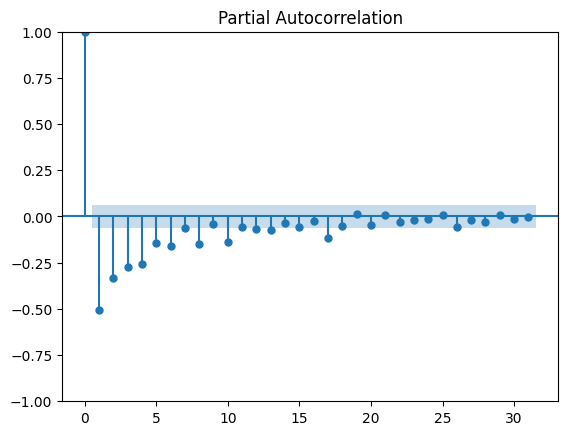

In [118]:
# autoregressive model

## -------- Select the order of the autoregressive model -------------
# Ensure Stationarity
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y_stationary'], label='Stationary Series')
plt.title('Stationary Series after Box-Cox Transformation')
plt.xlabel('Date')
plt.ylabel('Stationary Value')
plt.legend()
plt.show()

adf_test = sm.tsa.stattools.adfuller(df['y_stationary'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')


# find order of selection
plot_acf(train['y_stationary'])
plot_pacf(train['y_stationary'], method='ywm')

## ----------- Build AR model ------------
selector = ar_select_order(train['y_stationary'], 365)
ar_model = AutoReg(train['y_stationary'], lags=selector.ar_lags).fit()
print(ar_model.summary())

## ----------- Forecast using AR model -----------

# Get forecasts and convert to actual passenger volumes
transformed_forecasts = list(ar_model.forecast(steps=len(test)))
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['y_boxcox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts, lam)



# Plot the forecasts
plot_forecasts(forecasts, 'Autoregression')


## 📈 ARIMA (AutoRegressive Integrated Moving Average) Model

This section implements an ARIMA model to forecast the Box-Cox transformed time series. ARIMA is one of the most widely used models in time series forecasting and combines three components:

- **AR (AutoRegressive):** Uses past values to predict future ones  
- **I (Integrated):** Applies differencing to make the series stationary  
- **MA (Moving Average):** Uses past forecast errors in prediction

In this implementation, we use the `ARIMA()` class from `statsmodels`, which automatically handles differencing, so we pass the **Box-Cox transformed series** directly.

---

### 🛠️ Steps

1. **Fit ARIMA Model**
   - We specify the order (p=10, d=1, q=10)
   - Differencing (`d=1`) is handled internally

2. **Forecast and Invert Transformation**
   - Forecast future values on the transformed scale
   - Apply inverse Box-Cox to return to the original scale


### ✅ Strengths of ARIMA

- Handles **non-stationary** data through differencing
- Suitable for data with **autocorrelation** but without strong seasonality
- Flexible model with interpretable components

---

### ⚠️ Why ARIMA Struggles with Stock Prices

- **Stock prices are non-stationary and noisy**, with **no consistent trend** or autocorrelation
- ARIMA assumes **linearity and constant variance**, which often **don’t hold** in financial markets
- Fails to capture **volatility clustering** or **nonlinear patterns**
- More suited for **macroeconomic indicators** or **stable demand series** than for volatile instruments like individual equities



In [119]:
# ARIMA Model


# Build ARIMA model and inverse the boxcox
arima_model = ARIMA(train['y_boxcox'], order=(2, 1, 2)).fit()       # this class carries out differencing for us, so we only need to pass the Box-Cox transformed time series
boxcox_forecasts = arima_model.forecast(test_size)  
fcst_arima = inv_boxcox(boxcox_forecasts, lam)



plot_forecasts(fcst_arima, 'ARIMA Model')
arima_model.summary()




/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. U

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               y_boxcox   No. Observations:                 1005
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3469.170
Date:                Sat, 23 Aug 2025   AIC                           6948.341
Time:                        10:20:20   BIC                           6972.899
Sample:                             0   HQIC                          6957.673
                               - 1005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9613      0.141      6.796      0.000       0.684       1.239
ar.L2         -0.8017      0.108     -7.457      0.000      -1.012      -0.591
ma.L1         -0.9989      0.146     -6.856      0.000      -1.284      -0.713
ma.L2          0.7925      0.115      6.866      0.000       0.566       1.019
sigma2        58.7235      1.711     34.327      0.000      55.371      62.076
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               364.65
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               7.41   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ⚡ GARCH Model – Forecasting Volatility

The GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model is designed to **model and forecast the volatility of time series data**, especially financial returns that exhibit **volatility clustering** — periods of high and low variability grouped together.



---

### ✅ Strengths of GARCH

- Models **time-varying volatility** — key in financial time series
- Captures **volatility clustering**, a common feature in asset returns

---

### ⚠️ Notes

- Coefficients may not all be significant — consider simplifying the model (e.g., GARCH(1,1)) if overfitting is suspected
- GARCH models forecast **volatility**, not actual returns
- Requires **stationary** input (e.g., returns, not raw prices)


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4668.37
Distribution:                  Normal   AIC:                           9364.74
Method:            Maximum Likelihood   BIC:                           9433.52
                                        No. Observations:                 1005
Date:                Sat, Aug 23 2025   Df Residuals:                     1004
Time:                        10:20:20   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           142.5358      1.474     96.681      0.000 [1.

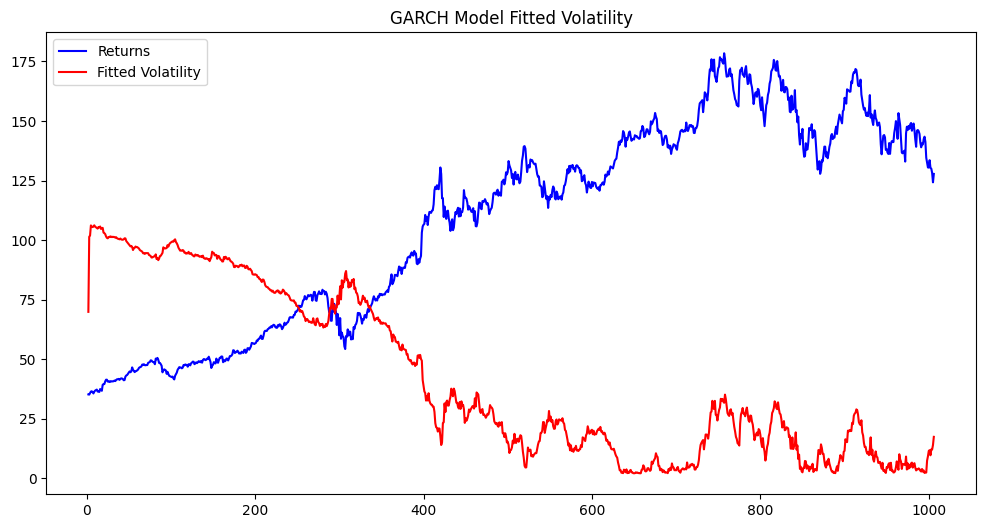

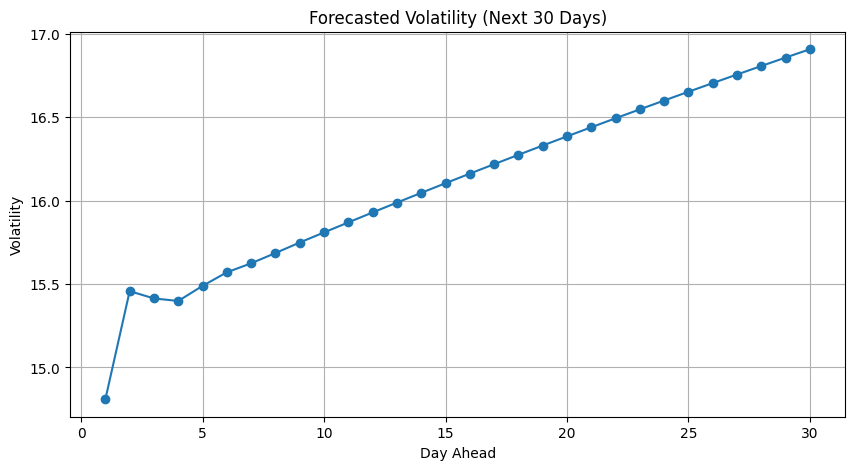

In [121]:
# GARCH Model, predict volatility of returns


model_arch = arch_model(train['y'], vol='Garch', p=6, q=6)
model_arch_fit = model_arch.fit(disp="off")
print(model_arch_fit.summary())   # some coefficients not significant

fitted_vol = model_arch_fit.conditional_volatility
forecast = model_arch_fit.forecast(horizon=30)
# Mean forecasted volatility for each horizon
predicted_vol = forecast.variance.values[-1, :] ** 0.5



plt.figure(figsize=(12,6))
plt.plot(train.index, train['y'], label='Returns', color='blue')
plt.plot(train.index, fitted_vol, label='Fitted Volatility', color='red')

plt.title('GARCH Model Fitted Volatility')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(range(1, 31), predicted_vol, marker='o')
plt.title('Forecasted Volatility (Next 30 Days)')
plt.xlabel('Day Ahead')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()


## 🎵 Harmonic Regression with Fourier Features

Harmonic regression models seasonal patterns using a combination of **sine and cosine waves** (Fourier terms). This technique is particularly useful for time series data with **cyclical** or **periodic** structures.

In this section, we integrate Fourier-transformed features with an **Auto-ARIMA** model to capture smooth seasonal components in the data.

---

### 🛠️ Steps

1. **Generate Fourier Features**
   - For each order from 1 to 9, compute corresponding sine and cosine terms using:
     \[
     \text{sin}\left(2\pi \cdot \text{order} \cdot \frac{\text{month}}{12}\right), \quad
     \text{cos}\left(2\pi \cdot \text{order} \cdot \frac{\text{month}}{12}\right)
     \]
   - These features model repeating seasonal cycles.

2. **Prepare Data**
   - Apply Box-Cox transformation to stabilize variance.
   - Split the data into train and test sets (80/20 split).
   - Identify Fourier features using column name patterns.

3. **Modeling with Auto-ARIMA**
   - Fit an Auto-ARIMA model using Fourier features as external regressors (`X`).
   - Disable seasonality (`seasonal=False`) since seasonality is captured by Fourier terms.
   - Use `aicc` as the information criterion for model selection.

4. **Forecast and Inverse Transform**
   - Generate predictions on the test set.
   - Apply inverse Box-Cox to recover actual scale.
   - Visualize predicted vs. actual values.

---

### ✅ Strengths

- Excellent for **cyclical patterns** and **smooth seasonal effects**
- Flexible — number of harmonics (Fourier terms) can be tuned
- Works with traditional linear models like ARIMA

---

### ⚠️ Limitations for Stock Data

- Assumes **periodic structure**, which stock prices typically lack
- Stock returns are often **non-stationary, volatile, and noisy**
- Fourier terms cannot capture **sudden shifts**, **jumps**, or **volatility clustering**
- Linear assumptions in ARIMA and Box-Cox transformation may not hold

> 🔍 As shown in the forecast plot, the model tends to produce **flat predictions** when applied to financial data lacking seasonality.

---

Let me know if you’d like a version of this using Prophet or generalized additive models (GAM)!


In [122]:
# Harmonic Regression

# Build auto-ARIMA model with fourier features

# ---- config ----
FOURIER_K = 3  # orders 1..K → 2K columns


def add_fourier_by_index(df, period, K):
    """
    Build Fourier sin/cos features using a continuous time index t=0..N-1.
    Suitable for daily equities with period ~252.
    """
    out = df.copy()
    t = np.arange(len(out), dtype=float)
    for k in range(1, K+1):
        out[f'fourier_sin_{period}_{k}'] = np.sin(2*np.pi*k*t/period)
        out[f'fourier_cos_{period}_{k}'] = np.cos(2*np.pi*k*t/period)
    return out

# ---- create Fourier features over the FULL series (deterministic) ----
df_fourier = add_fourier_by_index(df[['ds','y']].reset_index(drop=True), SP, FOURIER_K)

# ---- Box-Cox: fit lambda on TRAIN ONLY, apply to all ----
# assumes you already have `train` and `test` DataFrames from the same df
n_train = len(train)
y_bc_train, lam = boxcox(train['y'].values)          # fit λ on train
df_fourier['y_boxcox'] = boxcox(df_fourier['y'].values, lmbda=lam)  # transform full series with that λ

# ---- align Fourier split with your existing train/test boundary ----
train_fourier = df_fourier.iloc[:n_train].copy()
test_fourier  = df_fourier.iloc[n_train:n_train+H].copy()


# names of Fourier columns
fourier_features = [c for c in df_fourier.columns if c.startswith('fourier_')]

# ---- DHR: auto_arima on Box-Cox series with Fourier exogenous regressors (no seasonal ARIMA part) ----
model_harmonic = pm.auto_arima(
    train_fourier['y_boxcox'],
    X=train_fourier[fourier_features].values,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    information_criterion='aicc',
    error_action="ignore",
    max_p=3, max_q=3  # keep search modest; adjust if you like
)

# ---- forecast in Box-Cox space, then invert back to original y ----
boxcox_forecasts = model_harmonic.predict(
    n_periods=len(test_fourier),
    X=test_fourier[fourier_features].values
)
fcst_dhr = pd.Series(
    inv_boxcox(np.asarray(boxcox_forecasts), lam),
    index=test.index,                 # align to your test window
    name=f"DHR_Fourier{SP}_K{FOURIER_K}"
)


# Plot the forecasts
plot_forecasts(fcst_dhr, 'Harmonic Regression with Fourier Features')

/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be re

## 🔮 LSTM (Long Short-Term Memory) Neural Network

In this section, I build a Long Short-Term Memory (LSTM) model using PyTorch to forecast stock prices.

LSTM networks are a type of recurrent neural network (RNN) designed to capture **long-term dependencies**, making them particularly effective for sequential data like time series.

---

### 🧠 Why LSTM?

LSTMs are well-suited for modeling complex, nonlinear relationships in time series, especially when traditional models (like ARIMA or Holt-Winters) fail to capture the dynamics due to volatility or noise. They are commonly used in financial forecasting, speech recognition, and natural language processing.

---

### 🛠️ Implementation Steps

1. **Data Preprocessing**
   - Normalize the target series to \[0, 1\] using `MinMaxScaler`
   - Use a sliding window approach (`lookback = 7`) to create training sequences

2. **Model Definition**
   - Architecture: 2-layer LSTM with dropout for regularization and a fully connected output layer
   - Loss: Mean Squared Error (MSE)
   - Optimizer: Adam

3. **Training**
   - Trained over 200 epochs
   - Best model checkpointed based on lowest test loss

4. **Evaluation**
   - Predictions made on the test set and inverse-transformed to original scale
   - Visualize predicted vs. actual prices
   - Predict the next day's price based on the latest `lookback` days

---

### ✅ Strengths of LSTM

- Captures **nonlinear** and **complex patterns**
- Handles **long-range dependencies** in sequential data
- Learns patterns directly from data — no need to manually specify lags, trends, or seasonality
- Performs better than statistical models when data is **noisy or volatile**, like stock prices

---

### ⚠️ Limitations

- **Data-hungry**: Requires large amounts of training data to perform well
- **Computationally intensive**: Training deep neural networks takes longer
- **Overfitting risk**: Needs careful regularization and validation
- Difficult to interpret compared to traditional statistical models

---

### 📈 Result Preview

- Test set predictions closely track actual prices after sufficient training
- Next-day price forecast is generated using the last 7 days of data



Epoch 001 | train 0.167030 | val 0.353549  <-- best
Epoch 002 | train 0.089558 | val 0.151082  <-- best
Epoch 003 | train 0.053049 | val 0.023876  <-- best
Epoch 004 | train 0.051901 | val 0.077979
Epoch 005 | train 0.042834 | val 0.111473
Epoch 006 | train 0.040529 | val 0.076469
Epoch 007 | train 0.030938 | val 0.017192  <-- best
Epoch 008 | train 0.024243 | val 0.006544  <-- best
Epoch 009 | train 0.012820 | val 0.016019
Epoch 010 | train 0.007926 | val 0.009761
Epoch 011 | train 0.009201 | val 0.231681
Epoch 012 | train 0.007401 | val 0.004649  <-- best
Epoch 013 | train 0.004997 | val 0.033920
Epoch 014 | train 0.003940 | val 0.003536  <-- best
Epoch 015 | train 0.003280 | val 0.008449
Epoch 016 | train 0.002762 | val 0.012239
Epoch 017 | train 0.002212 | val 0.005513
Epoch 018 | train 0.001973 | val 0.014761
Epoch 019 | train 0.001850 | val 0.004691
Epoch 020 | train 0.001618 | val 0.005491
Epoch 021 | train 0.001516 | val 0.005120
Epoch 022 | train 0.001378 | val 0.003740
Epoch 

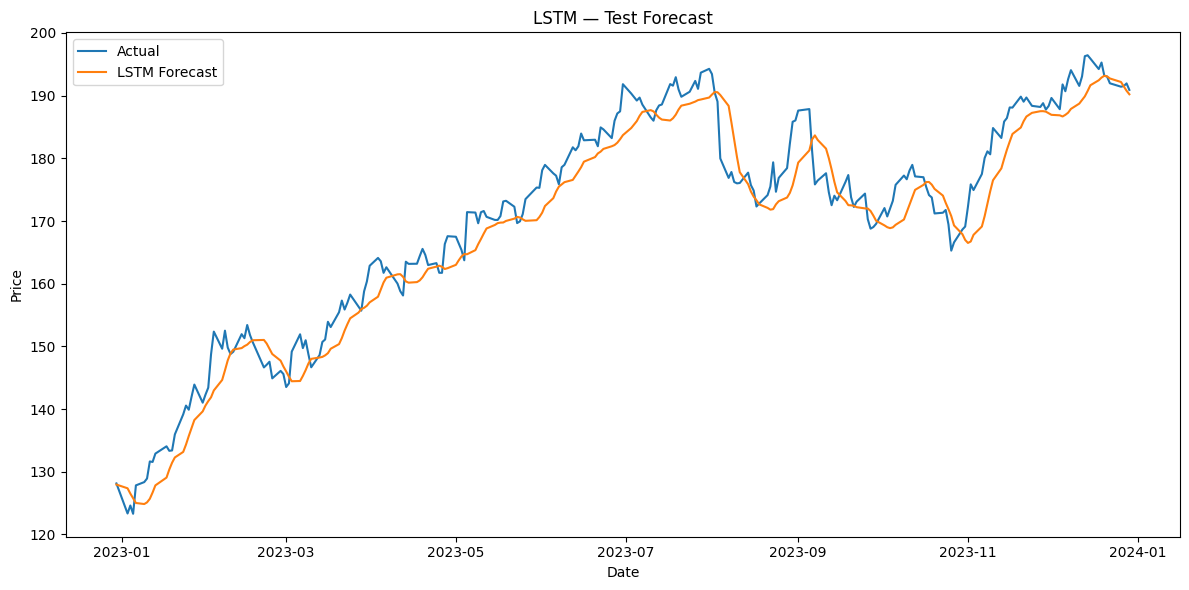

In [123]:
# ====== CONFIG ======
LOOKBACK   = 128
VAL_RATIO  = 0.10        # % of the FULL series; carved from the end of the training span
LR         = 1e-3
EPOCHS     = 200
BATCH_SIZE = 128
CLIP_NORM  = 1.0
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

# ====== DATA (keep test period same as other models) ======
# We use your existing split: `train` and `test` are already defined.
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim

df_local = df[['ds','y']].sort_values('ds').reset_index(drop=True)

# Indices that reproduce your split
N           = len(df_local)
test_start  = N - test_size
val_size    = max(int(VAL_RATIO * N), LOOKBACK*2)  # ensure enough points
val_start   = max(LOOKBACK, test_start - val_size) # validation starts inside the train span

# Extract target as float32
y_all = df_local[['y']].values.astype(np.float32)

# --- Fit scaler ONLY on the pure-train slice (no val/test leakage)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(y_all[:val_start])

# Transform full series for windowing
y_scaled = scaler.transform(y_all)

# --- Sequence builder (lookback → next step)
def create_sequences(arr2d, lookback):
    X, y = [], []
    for i in range(lookback, len(arr2d)):
        X.append(arr2d[i - lookback:i, 0])
        y.append(arr2d[i, 0])
    X = np.array(X, dtype=np.float32)[..., None]  # (n, lookback, 1)
    y = np.array(y, dtype=np.float32)[..., None]  # (n, 1)
    return X, y

# Slices with overlap for lookback
train_scaled = y_scaled[:val_start]
val_scaled   = y_scaled[val_start - LOOKBACK : test_start]
test_scaled  = y_scaled[test_start - LOOKBACK : ]

# --- Build sequences (NumPy) ---
X_train_np, y_train_np = create_sequences(train_scaled, LOOKBACK)
X_val_np,   y_val_np   = create_sequences(val_scaled,   LOOKBACK)
X_test_np,  y_test_np  = create_sequences(test_scaled,  LOOKBACK)

# --- To tensors / device (use *_t names to avoid clobbering) ---
X_train_t = torch.tensor(X_train_np, dtype=torch.float32).to(DEVICE)
y_train_t = torch.tensor(y_train_np, dtype=torch.float32).to(DEVICE)
X_val_t   = torch.tensor(X_val_np,   dtype=torch.float32).to(DEVICE)
y_val_t   = torch.tensor(y_val_np,   dtype=torch.float32).to(DEVICE)
X_test_t  = torch.tensor(X_test_np,  dtype=torch.float32).to(DEVICE)
y_test_t  = torch.tensor(y_test_np,  dtype=torch.float32).to(DEVICE)

# --- DataLoader ---
train_ds = torch.utils.data.TensorDataset(X_train_t, y_train_t)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)


# ====== MODEL ======
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)         # (B, T, H)
        last = out[:, -1, :]          # (B, H)
        return self.fc(last)          # (B, 1)

model_lstm     = LSTMModel().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=LR)

# ====== TRAIN (with validation & early stopping) ======
best_state    = None
best_val_loss = float("inf")
patience      = 20
since_improve = 0

for epoch in range(1, EPOCHS + 1):
    model_lstm.train()
    train_loss_sum, steps = 0.0, 0

    for xb, yb in train_loader:
        optimizer.zero_grad(set_to_none=True)
        pred = model_lstm(xb)
        loss = criterion(pred, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model_lstm.parameters(), CLIP_NORM)
        optimizer.step()
        train_loss_sum += loss.item()
        steps += 1

    train_loss = train_loss_sum / max(1, steps)

    model_lstm.eval()
    with torch.no_grad():
        val_pred  = model_lstm(X_val_t)
        val_loss  = criterion(val_pred, y_val_t).item()

    improved = val_loss < best_val_loss
    if improved:
        best_val_loss = val_loss
        best_state    = {k: v.detach().cpu().clone() for k, v in model_lstm.state_dict().items()}
        since_improve = 0
        print(f"Epoch {epoch:03d} | train {train_loss:.6f} | val {val_loss:.6f}  <-- best")
    else:
        since_improve += 1
        print(f"Epoch {epoch:03d} | train {train_loss:.6f} | val {val_loss:.6f}")

    if since_improve >= patience:
        print("Early stopping.")
        break

if best_state is not None:
    model_lstm.load_state_dict(best_state)

# ====== TEST EVAL (single final pass) ======
model_lstm.eval()
with torch.no_grad():
    preds_scaled = model_lstm(X_test_t).cpu().numpy()
    test_loss    = criterion(torch.tensor(preds_scaled), y_test_t.cpu()).item()
print(f"\nFinal TEST MSE (scaled): {test_loss:.6f}")

# Back to original scale (PRICE)
preds  = scaler.inverse_transform(preds_scaled)
actual = scaler.inverse_transform(y_test_t.cpu().numpy())

# Build Series aligned to your test window (same as other models)
fcst_lstm = pd.Series(
    preds[:, 0],
    index=test.index,          # aligns to your existing test period
    name="fcst_lstm"
)

# (Optional) quick plot
plt.figure(figsize=(12,6))
plt.plot(test['ds'].values, actual[:,0], label='Actual')
plt.plot(test['ds'].values, fcst_lstm.values, label='LSTM Forecast')
plt.title('LSTM — Test Forecast')
plt.xlabel('Date'); plt.ylabel('Price'); plt.legend(); plt.tight_layout(); plt.show()


In [125]:
plot_forecasts(fcst_lstm, 'Harmonic Regression with Fourier Features')

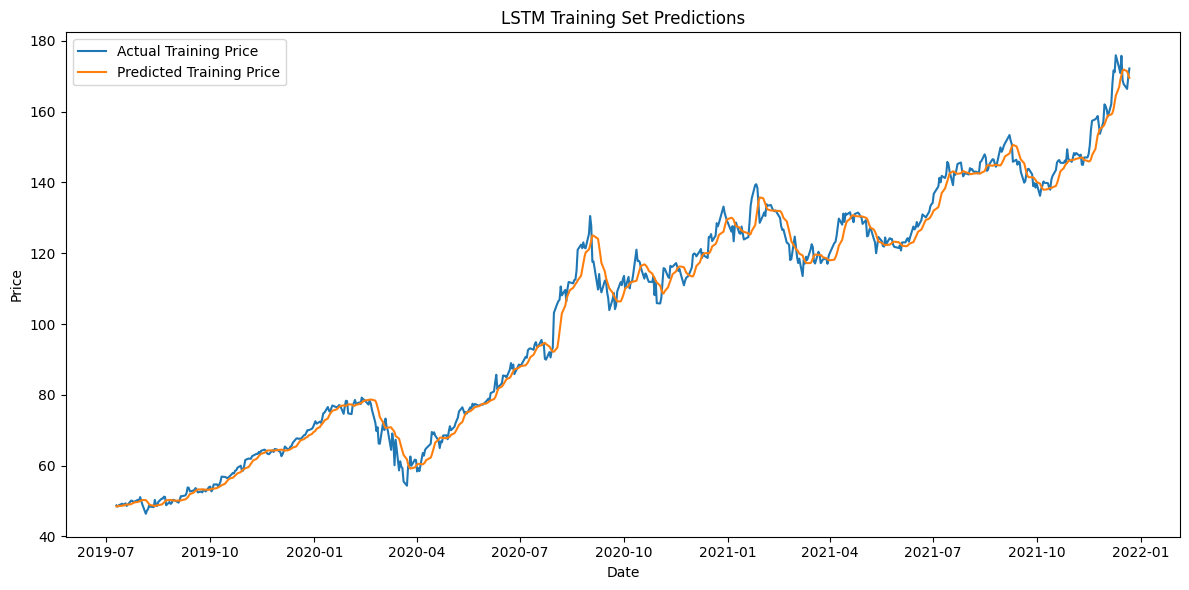

In [126]:
# Predict on training set
model_lstm.eval()
with torch.no_grad():
    train_predictions = model_lstm(X_train_t).numpy()

# Inverse transform
train_predictions = scaler.inverse_transform(train_predictions)
actual_train = scaler.inverse_transform(y_train_t.numpy())

# Get date range for training data
train_dates = df['ds'][LOOKBACK:N-test_size-val_size]  # skip first `lookback` rows due to sequence creation

# Plot predictions on training data
plt.figure(figsize=(12,6))
plt.plot(train_dates, actual_train, label='Actual Training Price')
plt.plot(train_dates, train_predictions, label='Predicted Training Price')
plt.title("LSTM Training Set Predictions")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()



In [133]:
# ========================
# Build metrics table 
# ========================

# If fcst_lstm is a Series, convert to 1D array

fcst_lstm_arr = fcst_lstm.values if isinstance(fcst_lstm, pd.Series) else np.asarray(fcst_lstm)

models = {
    f"Seasonal-Naive (m={SP})":                  fcst_snaive,
    f"ETS ({seasonal_kind})":            fcst_ets,
    f"ARIMA (2,1,2)_{SP}":               fcst_arima,
    f"DHR (K={FOURIER_K}) + ARMA(1,1) errors":   fcst_dhr,
    f"LSTM (lookback={LOOKBACK})":               fcst_lstm,
}

rows = []
baseline_rmse = rmse(y_test, models[f"Seasonal-Naive (m={SP})"])

for name, yhat in models.items():
    yhat = np.asarray(yhat).reshape(-1)  # guard to 1-D
    r = rmse(y_test, yhat)
    rows.append({
        "Model": name,
        "sMAPE": smape(y_test, yhat),
        "RMSE":  r,
        "MAE":   mae(y_test, yhat),
        "MASE":  mase(y_train, y_test, yhat, m=SP),
        "Baseline Δ (RMSE)": "—" if "Seasonal-Naive" in name
                              else f"↓{(baseline_rmse - r)/baseline_rmse*100:.1f}%",
    })

metrics_df = pd.DataFrame(rows).reset_index(drop=True)
print(metrics_df.to_string(index=False))


                       Model     sMAPE      RMSE       MAE     MASE Baseline Δ (RMSE)
      Seasonal-Naive (m=252) 17.650421 32.937924 28.475875 0.780108                 —
                   ETS (mul) 31.721133 50.678152 47.306052 1.295968           ↓-53.9%
           ARIMA (2,1,2)_252 28.469835 46.626963 43.299910 1.186218           ↓-41.6%
DHR (K=3) + ARMA(1,1) errors 25.026752 40.974774 38.432466 1.052873           ↓-24.4%
         LSTM (lookback=128)  2.062860  4.162131  3.463178 0.094875            ↓87.4%


In [ ]:
# ========================
# Plot all forecasts
# ========================

def _to_series(yhat, test_index, name):
    """Align a forecast (Series or array) to test.index as a pandas Series."""
    if isinstance(yhat, pd.Series):
        s = yhat.reindex(test_index)
    else:
        arr = np.asarray(yhat).reshape(-1)
        if len(arr) != len(test_index):
            arr = arr[-len(test_index):]  # last-resort trim
        s = pd.Series(arr, index=test_index)
    s.name = name
    return s.astype(float)

def plot_many_forecasts(test_df, forecasts: dict, title="Forecasts vs Actual", outpath="figures/forecast_comparison.png"):
    """
    forecasts: dict like {"Seasonal-Naive (m=252)": fcst_snaive, "ETS": fcst_ets, ...}
               values can be Series (aligned) or numpy arrays (len == len(test))
    """
    # Ensure output folder
    os.makedirs(os.path.dirname(outpath), exist_ok=True)

    # Align everything to test.index
    aligned = {name: _to_series(yhat, test_df.index, name) for name, yhat in forecasts.items()}

    # Build the figure
    plt.figure(figsize=(12, 6))
    # Actual
    plt.plot(test_df["ds"], test_df["y"], label="Actual", linewidth=2)

    # Forecasts
    for name, s in aligned.items():
        # Optional: drop any non-finite points to avoid broken lines
        mask = np.isfinite(s.values)
        plt.plot(test_df["ds"][mask], s.values[mask], label=name)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend(loc="best", ncols=2)  # compact legend
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()
    print(f"Saved: {outpath}")

# ---------- Example usage ----------
H = len(test)  # horizon
forecasts = {
    f"Seasonal-Naive (m={SP})": fcst_snaive,
    f"ETS (mul{' + damped' if False else ''})": fcst_ets,   # edit label as you like
    "ARIMA (2,1,2)":            fcst_arima,
    f"DHR (K={FOURIER_K})":     fcst_dhr,
    f"LSTM (lookback={LOOKBACK})": fcst_lstm,
}

plot_many_forecasts(test, forecasts, title="All Models — Test Window", outpath="figures/forecast_comparison.png")


Saved: figures/forecast_comparison.png
